In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /home/<username>/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT I

## config

In [3]:
random_seed = 26
image_size = 128

# affect select which type data
# and path of generated result to save
# and path of trained model name
gen_type = "normal"
root_dir = f"./latent_diffusion"
model_path = f"./{root_dir}/model"
os.makedirs(root_dir, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

AUGMENTATION_GAN_root_dir = "./AUGMENTATION_GAN"
CLASSIC_AUG_DIR = os.path.join(AUGMENTATION_GAN_root_dir, 'train_classic', '3000')

normal_src_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train', 'normal')
normal_500_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '500', 'normal')
normal_1000_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '1000', 'normal')
normal_2000_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '2000', 'normal')

# normal_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '3000', 'normal')
covid_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '3000', 'covid')
pneumonia_bac_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '3000', 'pneumonia_bac')
pneumonia_vir_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '3000', 'pneumonia_vir')

## setup random seed

In [4]:
set_determinism(random_seed)

## prepare train/val dataloader

In [5]:
def get_files(path):
    return [os.path.join(path, i) for i in os.listdir(path) if i.endswith("jpeg") or i.endswith("jpg") or i.endswith("png")]
            
gen_training_img = {
    'normal': get_files(normal_src_dir) +\
            get_files(normal_500_dir) +\
            get_files(normal_1000_dir) 
            # get_files(normal_2000_dir)
}

In [6]:
images = [{'image': i} for i in  gen_training_img[gen_type]]
train_imgs, val_imgs = train_test_split(images)

In [7]:
print(f"training images: {len(train_imgs)}, val images: {len(val_imgs)}")

training images: 802, val images: 268


In [8]:
image_size

128

In [9]:
from PIL import Image

class ChestDataset(Dataset):
    def __init__(self, imgs, label, transform=None):
        self.transform = transform
        self.imgs = imgs
        self.label = label

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = Image.open(self.imgs[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return {'image': image}

train_transforms = transforms.Compose([
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Resized(keys="image", spatial_size=(128, 128)),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            # rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)

val_transforms = transforms.Compose([
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.Resized(keys="image", spatial_size=(128, 128)) 
    ]
)

train_ds = Dataset(data = train_imgs, transform = train_transforms)
val_ds = Dataset(data = val_imgs, transform = val_transforms)
train_loader = DataLoader(
    train_ds, 
    batch_size=32, 
    shuffle=True, 
    num_workers=8, 
    # pin_memory=True
)
val_loader = DataLoader(
    val_ds, 
    batch_size=32, 
    shuffle=True, 
    num_workers=8, 
    # pin_memory=True
)

## display from train and val dataloader

In [10]:
for img in train_loader:
    print(img['image'].shape)
    break

torch.Size([32, 3, 128, 128])


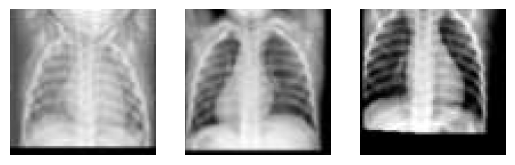

In [11]:
train_demo = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(train_demo["image"][image_n, 0, :, :].T, cmap="gray")
    ax[image_n].axis("off")

In [12]:
for img in val_loader:
    print(img['image'].shape)
    break

torch.Size([32, 3, 128, 128])


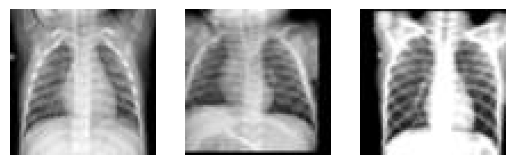

In [13]:
train_demo = first(val_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(train_demo["image"][image_n, 0, :, :].T, cmap="gray")
    ax[image_n].axis("off")

## training

In [20]:
import torch.nn as nn

device = torch.device("cuda:1")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
# autoencoderkl = nn.DataParallel(autoencoderkl)
autoencoderkl = autoencoderkl.to(device)

In [21]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

In [22]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=3, out_channels=3)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [23]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

In [24]:
len(train_loader)

26

In [25]:
kl_weight = 1e-6
n_epochs = 300
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

best_val_loss_autoencoder = float('inf')

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)

        # Save the autoencoder model if it has the best validation loss so far
        if val_loss < best_val_loss_autoencoder:
            best_val_loss_autoencoder = val_loss
            torch.save(autoencoderkl.state_dict(), os.path.join(model_path, f"{gen_type}_best_autoencoderkl.pth"))
            print(f"Saved better autoencoder model at epoch {epoch + 1} with val loss: {val_loss:.4f}")

        
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 0:  96%|███████████████████▏| 25/26 [00:10<00:00,  2.46it/s, recons_loss=0.212, gen_loss=0, disc_loss=0]/home/chilin/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 9: 100%|███████████████████| 26/26 [00:17<00:00,  1.47it/s, recons_loss=0.0552, gen_loss=0, disc_loss=0]


Saved better autoencoder model at epoch 10 with val loss: 0.0562
epoch 10 val loss: 0.0562


Epoch 11:  96%|██████████▌| 25/26 [00:18<00:00,  1.35it/s, recons_loss=0.0417, gen_loss=1.27, disc_loss=0.787]/home/chilin/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/torch/_tensor.py:1443: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  ret = func(*args, **kwargs)
Epoch 19: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.0348, gen_loss=0.271, disc_loss=0.263]


Saved better autoencoder model at epoch 20 with val loss: 0.0295
epoch 20 val loss: 0.0295


Epoch 29: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s, recons_loss=0.0306, gen_loss=0.376, disc_loss=0.255]


epoch 30 val loss: 0.0343


Epoch 39: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.0275, gen_loss=0.459, disc_loss=0.174]


epoch 40 val loss: 0.0301


Epoch 49: 100%|███████████| 26/26 [00:18<00:00,  1.40it/s, recons_loss=0.028, gen_loss=0.514, disc_loss=0.187]


Saved better autoencoder model at epoch 50 with val loss: 0.0224
epoch 50 val loss: 0.0224


Epoch 59: 100%|██████████| 26/26 [00:18<00:00,  1.40it/s, recons_loss=0.0241, gen_loss=0.568, disc_loss=0.194]


epoch 60 val loss: 0.0351


Epoch 69: 100%|███████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.025, gen_loss=0.687, disc_loss=0.104]


epoch 70 val loss: 0.0229


Epoch 79: 100%|███████████| 26/26 [00:19<00:00,  1.37it/s, recons_loss=0.0257, gen_loss=0.615, disc_loss=0.13]


epoch 80 val loss: 0.0280


Epoch 89: 100%|██████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.0222, gen_loss=0.857, disc_loss=0.069]


epoch 90 val loss: 0.0263


Epoch 99: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.0252, gen_loss=1.01, disc_loss=0.0171]


Saved better autoencoder model at epoch 100 with val loss: 0.0216
epoch 100 val loss: 0.0216


Epoch 109: 100%|█████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.0264, gen_loss=0.788, disc_loss=0.158]


epoch 110 val loss: 0.0250


Epoch 119: 100%|█████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.0226, gen_loss=0.798, disc_loss=0.467]


epoch 120 val loss: 0.0262


Epoch 129: 100%|█████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.0212, gen_loss=0.687, disc_loss=0.129]


Saved better autoencoder model at epoch 130 with val loss: 0.0188
epoch 130 val loss: 0.0188


Epoch 139: 100%|█████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.0244, gen_loss=0.503, disc_loss=0.208]


epoch 140 val loss: 0.0309


Epoch 149: 100%|█████████| 26/26 [00:18<00:00,  1.40it/s, recons_loss=0.0253, gen_loss=0.414, disc_loss=0.233]


epoch 150 val loss: 0.0221


Epoch 159: 100%|████████████| 26/26 [00:18<00:00,  1.41it/s, recons_loss=0.0213, gen_loss=0.52, disc_loss=0.2]


epoch 160 val loss: 0.0209


Epoch 169: 100%|█████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.0203, gen_loss=0.354, disc_loss=0.237]


epoch 170 val loss: 0.0205


Epoch 179: 100%|█████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.0187, gen_loss=0.351, disc_loss=0.222]


epoch 180 val loss: 0.0213


Epoch 189: 100%|███████████| 26/26 [00:18<00:00,  1.38it/s, recons_loss=0.021, gen_loss=0.292, disc_loss=0.28]


Saved better autoencoder model at epoch 190 with val loss: 0.0167
epoch 190 val loss: 0.0167


Epoch 199: 100%|█████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.0218, gen_loss=0.481, disc_loss=0.154]


epoch 200 val loss: 0.0228


Epoch 209: 100%|██████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.017, gen_loss=0.305, disc_loss=0.245]


epoch 210 val loss: 0.0240


Epoch 219: 100%|█████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.0198, gen_loss=0.286, disc_loss=0.278]


epoch 220 val loss: 0.0172


Epoch 229: 100%|█████████| 26/26 [00:18<00:00,  1.39it/s, recons_loss=0.0194, gen_loss=0.339, disc_loss=0.265]


epoch 230 val loss: 0.0167


Epoch 239: 100%|███████████| 26/26 [00:18<00:00,  1.42it/s, recons_loss=0.016, gen_loss=0.32, disc_loss=0.237]


Saved better autoencoder model at epoch 240 with val loss: 0.0160
epoch 240 val loss: 0.0160


Epoch 249: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s, recons_loss=0.018, gen_loss=0.374, disc_loss=0.251]


epoch 250 val loss: 0.0211


Epoch 259: 100%|█████████| 26/26 [00:18<00:00,  1.41it/s, recons_loss=0.0239, gen_loss=0.331, disc_loss=0.226]


epoch 260 val loss: 0.0170


Epoch 269: 100%|█████████| 26/26 [00:18<00:00,  1.40it/s, recons_loss=0.0181, gen_loss=0.338, disc_loss=0.241]


epoch 270 val loss: 0.0182


Epoch 279: 100%|█████████| 26/26 [00:18<00:00,  1.40it/s, recons_loss=0.0179, gen_loss=0.339, disc_loss=0.236]


Saved better autoencoder model at epoch 280 with val loss: 0.0140
epoch 280 val loss: 0.0140


Epoch 289: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s, recons_loss=0.019, gen_loss=0.353, disc_loss=0.223]


epoch 290 val loss: 0.0187


Epoch 299: 100%|████████| 26/26 [00:18<00:00,  1.42it/s, recons_loss=0.0159, gen_loss=0.832, disc_loss=0.0439]


Saved better autoencoder model at epoch 300 with val loss: 0.0118
epoch 300 val loss: 0.0118


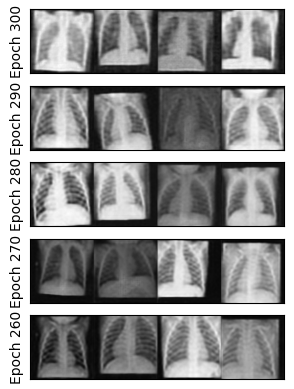

In [26]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

In [27]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

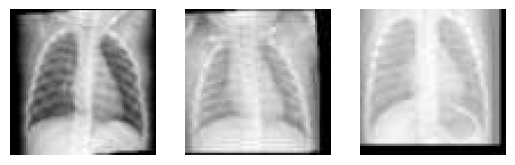

In [28]:
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :].T, cmap="gray")
    ax[image_n].axis("off")

In [29]:
autoencoderkl.load_state_dict(torch.load(os.path.join(model_path, f"{gen_type}_best_autoencoderkl.pth")))
autoencoderkl.eval()

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (3): Downsample(
        (conv): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (4-5): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(3

In [30]:
with torch.no_grad():
    with autocast(enabled=True):
        # z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9455165863037109


In [31]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

Epoch 19: 100%|███████████| 26/26 [00:10<00:00,  2.53it/s, loss=0.157]


Epoch 19 val loss: 0.1945
Saved improved model with validation loss 0.1945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.69it/s]


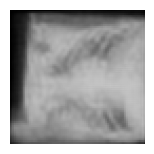

Epoch 39: 100%|███████████| 26/26 [00:09<00:00,  2.60it/s, loss=0.147]


Epoch 39 val loss: 0.1731
Saved improved model with validation loss 0.1731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.21it/s]


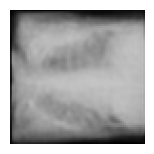

Epoch 59: 100%|███████████| 26/26 [00:10<00:00,  2.56it/s, loss=0.156]


Epoch 59 val loss: 0.1421
Saved improved model with validation loss 0.1421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.76it/s]


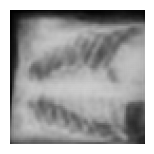

Epoch 79: 100%|███████████| 26/26 [00:10<00:00,  2.58it/s, loss=0.142]


Epoch 79 val loss: 0.1570


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.42it/s]


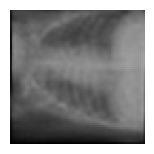

Epoch 99: 100%|███████████| 26/26 [00:09<00:00,  2.69it/s, loss=0.166]


Epoch 99 val loss: 0.1747


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.57it/s]


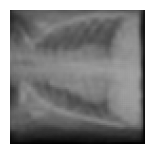

Epoch 119: 100%|██████████| 26/26 [00:09<00:00,  2.65it/s, loss=0.155]


Epoch 119 val loss: 0.1435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.48it/s]


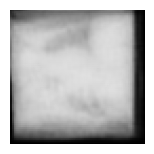

Epoch 139: 100%|██████████| 26/26 [00:09<00:00,  2.63it/s, loss=0.142]


Epoch 139 val loss: 0.1629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.94it/s]


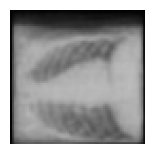

Epoch 159: 100%|██████████| 26/26 [00:09<00:00,  2.65it/s, loss=0.144]


Epoch 159 val loss: 0.1300
Saved improved model with validation loss 0.1300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.28it/s]


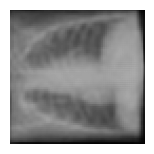

Epoch 179: 100%|██████████| 26/26 [00:10<00:00,  2.59it/s, loss=0.138]


Epoch 179 val loss: 0.1660


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.68it/s]


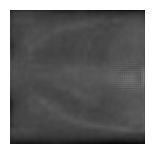

Epoch 199: 100%|███████████| 26/26 [00:10<00:00,  2.58it/s, loss=0.15]


Epoch 199 val loss: 0.1326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.32it/s]


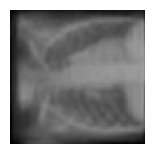

Epoch 219: 100%|██████████| 26/26 [00:09<00:00,  2.64it/s, loss=0.133]


Epoch 219 val loss: 0.1461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.80it/s]


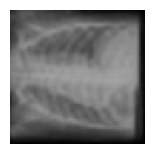

Epoch 239: 100%|██████████| 26/26 [00:09<00:00,  2.65it/s, loss=0.153]


Epoch 239 val loss: 0.1398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.41it/s]


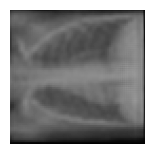

Epoch 259: 100%|██████████| 26/26 [00:10<00:00,  2.57it/s, loss=0.152]


Epoch 259 val loss: 0.1428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.88it/s]


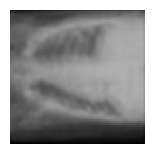

Epoch 279: 100%|███████████| 26/26 [00:09<00:00,  2.62it/s, loss=0.14]


Epoch 279 val loss: 0.1483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.26it/s]


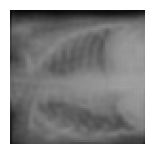

Epoch 299: 100%|██████████| 26/26 [00:09<00:00,  2.62it/s, loss=0.151]


Epoch 299 val loss: 0.1373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.62it/s]


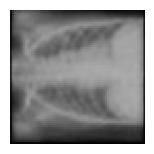

In [32]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 300
val_interval = 20
epoch_losses = []
val_losses = []
scaler = GradScaler()

best_val_loss = float('inf')  

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    # autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            # z_mu, z_sigma = autoencoderkl.module.encode(images)
            z_mu, z_sigma = autoencoderkl.encode(images)
            # z = autoencoderkl.module.sampling(z_mu, z_sigma)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    # z_mu, z_sigma = autoencoderkl.module.encode(images)
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    # z = autoencoderkl.module.sampling(z_mu, z_sigma)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), os.path.join(model_path, f"{gen_type}_best_unet_model.pth"))

            print(f"Saved improved model with validation loss {best_val_loss:.4f}")
        
        # Sampling image during training
        z = torch.randn((1, 3, 32, 32))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()

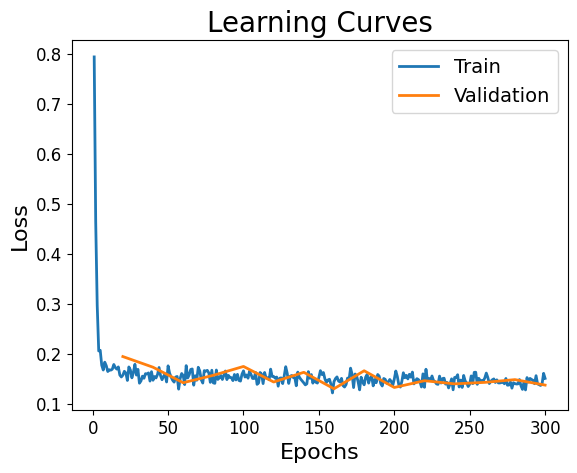

In [33]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

In [35]:
unet.eval()
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 32, 32))
noise = noise.to(device)

with torch.no_grad():
    image, intermediates = inferer.sample(
        input_noise=noise,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.76it/s]


(-0.5, 1279.5, 127.5, -0.5)

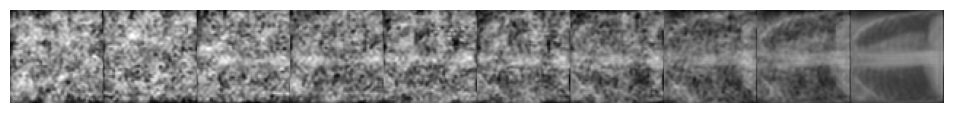

In [36]:
# Decode latent representation of the intermediary images
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

In [31]:
image.shape

torch.Size([1, 3, 128, 128])

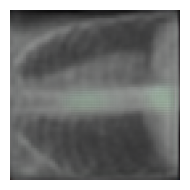

In [37]:
import torchvision.transforms.functional as F

for i in image:
    plt.figure(figsize=(2, 2))
    # chain = torch.cat(image, dim=-1)
    plt.style.use("default")
    plt.imshow(F.to_pil_image(i.cpu()), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()